In [1]:
from tenLoader import TenVideoDataset, normalize, TenVideoTest, TenVideoInfer
from model import BaseFeatup
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json
from loss import order_loss, chamer_distance_loss
import random
import time

In [2]:
dataset = TenVideoDataset()
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
testset = TenVideoTest()

In [3]:
video_idx, pre_idx, fir_img, pre_img, cur_img, fir_bou, pre_bou, cur_bou = next(iter(data_loader))
pre_idx

tensor([1])

In [4]:
model = BaseFeatup()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
# load model
model.load_state_dict(torch.load('./model/featup_10.pth'))

<All keys matched successfully>

In [6]:
model = model.cuda()
results = model(
    fir_img.cuda(),
    fir_bou.cuda(),
    pre_img.cuda(),
    cur_img.cuda(),
    pre_bou.cuda(),
)

/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
testset = TenVideoTest()
test_testset = TenVideoTest("./10video/train/total_data.json")
model_infer = TenVideoInfer(testset)
test_model_infer = TenVideoInfer(test_testset)

In [8]:
model_infer.infer_model(model)

In [9]:
model_infer.get_total_iou()

0.1718474683491462

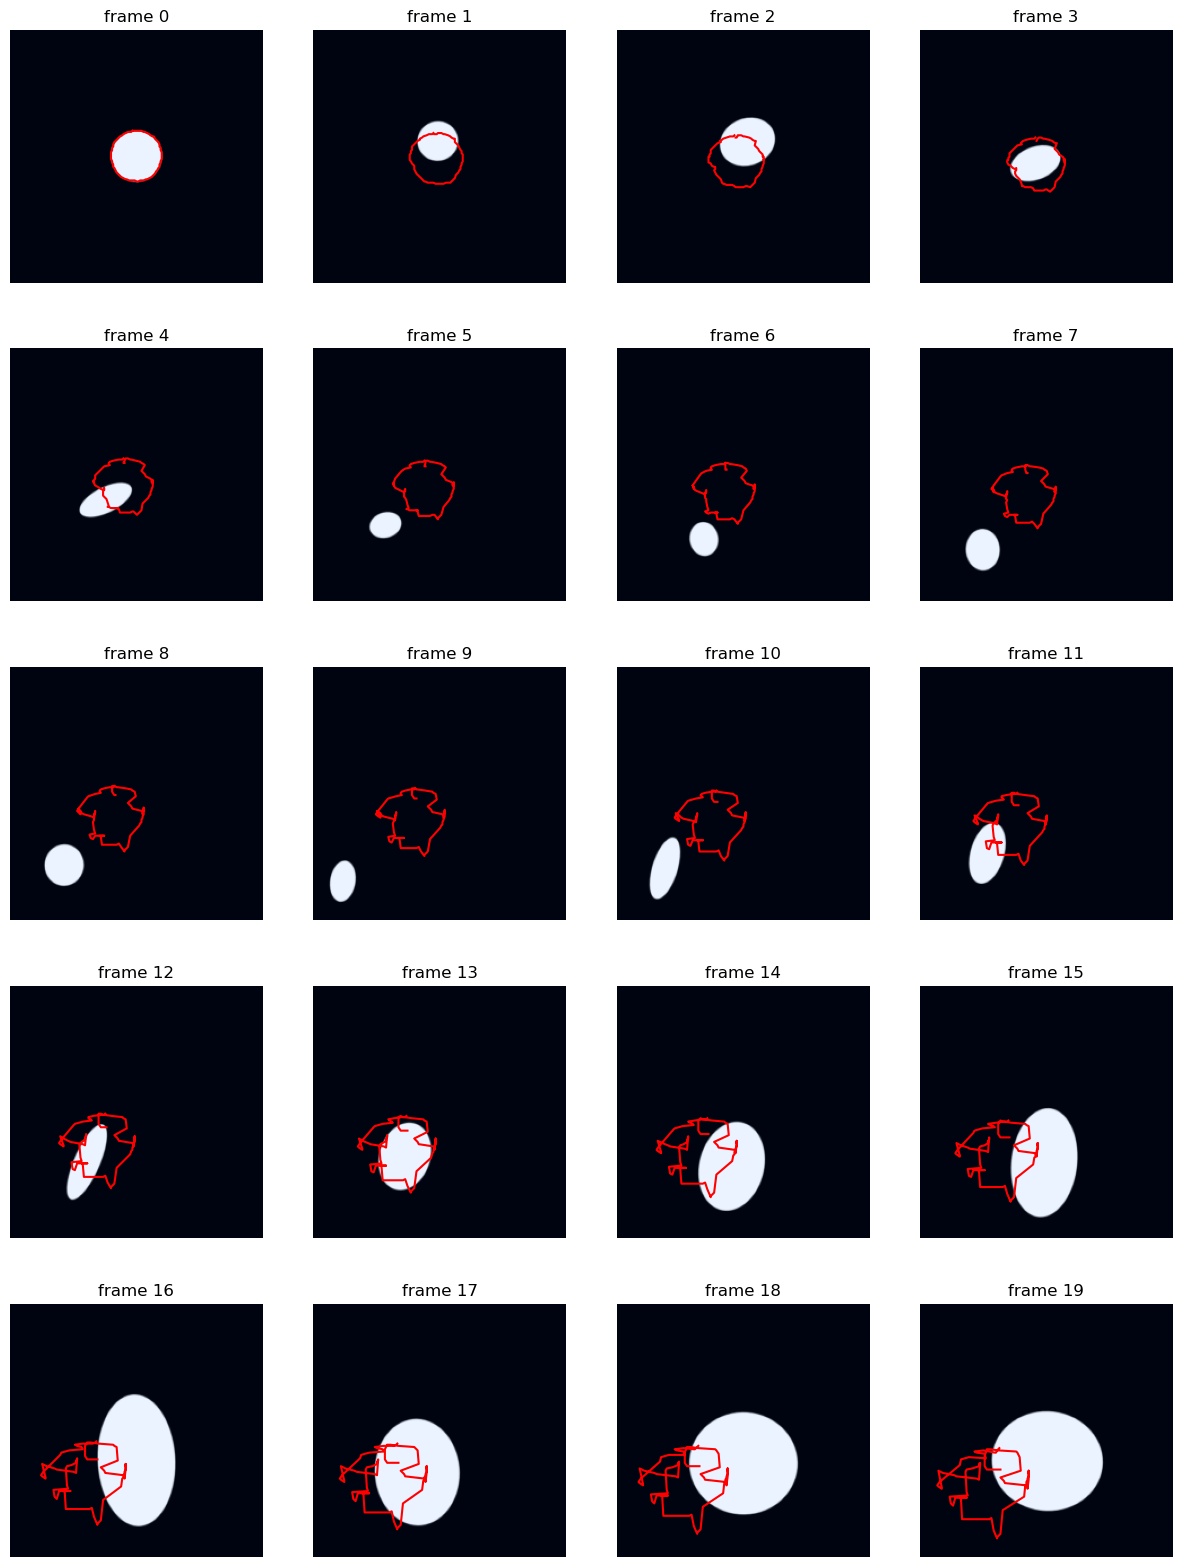

In [11]:
model_infer.show_infer_result(4, 0)

In [19]:
model = BaseFeatup().cuda()
testset = TenVideoTest()
model_infer = TenVideoInfer(testset)
dataset = TenVideoDataset()
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [18]:
dict_loss = {}
dict_iou = {}
interval_epochs = 30
interval_num = 5
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
gradient_clip = 0
epoch_index = 0

In [20]:
print(f"Start training at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}")
for interval in range(interval_num):
    for e in range(interval_epochs):
        model.train()
        mean_loss = 0
        for video_idx, pre_idx, fir_img, pre_img, cur_img, fir_bou, pre_bou, cur_bou in data_loader:
            pre_idx = pre_idx.item()
            video_idx = video_idx.item()
            pre_bou = model_infer.get_boundary(video_idx, pre_idx)
            pre_bou = pre_bou.unsqueeze(0).cuda()
            optimizer.zero_grad()
            results = model(
                fir_img.cuda(),
                fir_bou.cuda(),
                pre_img.cuda(),
                cur_img.cuda(),
                pre_bou.cuda(),
            )
            refine_num = len(results)
            loss = 0
            for i in range(refine_num):
                loss += 0.8 ** (refine_num - i - 1) * order_loss(results[i], cur_bou.cuda())
            loss.backward()
            if gradient_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            optimizer.step()
            mean_loss += loss.item()
        mean_loss /= len(data_loader)
        print(
            f"{time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}: Epoch {epoch_index}: Loss: {mean_loss:.4f}"
        )
        dict_loss[epoch_index] = mean_loss
        epoch_index += 1
    model_infer.infer_model(model)
    model_infer.show_infer_result(4, 0)
    print(
        f"{time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}: IoU in video 4:", model_infer.get_video_iou(4)
    )
    total_iou = model_infer.get_total_iou()
    dict_iou[epoch_index] = total_iou
    print(f"{time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}: Epoch {epoch_index}: Total IoU {total_iou:.4f}")
    if interval_epochs > 20:
        interval_epochs -= 10

Start training at 2024-04-11 18:12:38
2024-04-11 18:14:18: Epoch 0: Loss: 54.1953
2024-04-11 18:15:59: Epoch 1: Loss: 54.1931
2024-04-11 18:17:40: Epoch 2: Loss: 54.1853
2024-04-11 18:19:16: Epoch 3: Loss: 54.1859
2024-04-11 18:20:57: Epoch 4: Loss: 54.1804
2024-04-11 18:22:37: Epoch 5: Loss: 54.1933
2024-04-11 18:24:17: Epoch 6: Loss: 54.1824


KeyboardInterrupt: 